#PSG-Audio_download_dataset.ipynb
This open access polysomnography dataset contains multiple channels including two high-quality audio channels.  The download takes a long time, approximately 25 minutes per subject.  This notebook downloads the files associated with a single patient, extracts the labels from the .rml file, extracts the first nine 200Hz sample rate channels (downsampled to 100Hz), the second three 100Hz channels, and the 500Hz audio 'snore' channel (stored in 5 columns) from the edf files which are hour long recordings.

No data is stored in this repository. If you use the dataset please follow the original author's citation requests.

Paper: https://www.nature.com/articles/s41597-021-00977-w

Download: https://www.scidb.cn/en/detail?dataSetId=778740145531650048

NOTE:  The two high-quality audio channels are downloaded as they are included in the datafiles, however these signals are not processed or stored due to size limitations. 

The output is a load_data Intermediate Representation 1 (IR1) Pandas dataframe with rows = samples and colums = signal channels + event family labels + sub number.   If run in google colab the dataframe may be saved to a mounted drive.

I've mostly structured this as cell with a function + a small unit test or example.  Set interactive to true to run the Jupyter Notebook version.
At some point I may make this callable as a python notebook but this version has not been tested in that way.

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

[Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  
TODO:
* Figure out a way to download the list of URLs from the site - you can click the website's button but I haven't found a way to automate it.
* Several options like save README.txt for each subject and store pickles compressed should be configurable using parameters.   Not sure how often this notebook will need to be run though, the output has pretty much everything in the dataset (except for the high-fidelity audio channels).
* It would be better to have a single readme including the data from all subjects but since this is run in parts it would require reading a stored readme and appending for each multi-session pass.
* The selection of subjects could be automated - check to see if subject's IR1 is in the target directory, download if not.   Again, not sure how often this entire thing will need to be run, might not be worth it.

In [7]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
import io # to grab output of df.info() in order to save to readme file
import zipfile # to build a zipfile to which new files can be added
#from shutil import make_archive # to create zip for storage
#import requests #for downloading zip file
#from scipy import io #for loadmat, matlab conversion
import time
from datetime import timedelta
import csv
import pandas as pd
import numpy as np
import pickle # to save lists and dictionaries as files that can go into zip
from numpy import savetxt
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder # to encode strings to ints
from tabulate import tabulate # for verbose tables, showing data
# from tensorflow.keras.utils import to_categorical # for one-hot encoding
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
#import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from time import gmtime, strftime, localtime #for displaying Linux UTC timestamps in hh:mm:ss
from datetime import datetime, date, timedelta
import urllib.request # to get files from web w/o !wget

In [8]:
my_dir = '.' # replace with absolute path if desired
interactive = True # for exploring data and functions interactively
verbose = True
# setup a global readme so various methods can append info as needed
readme = 'This readme auto-generated by PSG-Audio_download_dataset.ipynb\n'
readme += 'Executed on '
today = date.today()
readme += today.strftime("%B %d, %Y") + "\n"
readme += 'ref: https://github.com/imics-lab/load_data_time_series \n'

# This chunk of code processes the list of URLs
requires a local copy from GET ALL URLS on https://www.scidb.cn/en/detail?dataSetId=778740145531650048

In [9]:
def get_sub_from_url(url_in):
    """returns the int subject number from the PSG-Audio url string"""
    sub_str = url_in.split("fileName=0000",1)[1]
    sub_str = sub_str.split("-",1)[0]
    sub_num = int(sub_str)
    return sub_num
if interactive:
    sub = get_sub_from_url(url_in = 'https://download.scidb.cn/download?fileId=61a0ca3f89f14b48842cf1ee&dataSetType=personal&fileName=00000995-100507_002.edf')
    print('extracted sub is',sub, "type is", type(sub))

extracted sub is 995 type is <class 'int'>


In [10]:
def get_fname_from_url(url_in):
    """removes common characters and url specific encoding from PSG-Audio URLs"""
    if get_sub_from_url(url_in) < 1000:
        my_fname = url_in.split("fileName=00000",1)[1] # kludge for 3-digit case
    else:    
        my_fname = url_in.split("fileName=0000",1)[1]
    my_fname = my_fname.replace('%5B','_') # change url encoding for [ to _
    my_fname = my_fname.replace('%5D','') # same for ] but no _
    my_fname = my_fname.replace('-100507','') # this is same for all files
    return my_fname
if interactive:
    my_fname = get_fname_from_url(url_in = 'https://download.scidb.cn/download?fileId=61a0ca3f89f14b48842cf1ee&dataSetType=personal&fileName=00000995-100507_002.edf')
    print('extracted fname (3-digit) is',my_fname)
    my_fname = get_fname_from_url(url_in = 'https://download.scidb.cn/download?fileId=62295e1ed7561b594fb680f1&dataSetType=personal&fileName=00001640-100507%5B002%5D.edf')
    print('extracted fname (4-digit) is',my_fname)
    my_fname = get_fname_from_url(url_in = 'https://download.scidb.cn/download?fileId=62295e17d7561b594fb67f5b&dataSetType=personal&fileName=00001640-100507.rml')
    print('extracted fname (rml) is',my_fname)

extracted fname (3-digit) is 995_002.edf
extracted fname (4-digit) is 1640_002.edf
extracted fname (rml) is 1640.rml


In [11]:
def get_url_df():
    """reads local txt file of all URLS for PSG-Audio, drops non-edf/rtf lines,
    adds a sub number column, only keeps "clean .rtf" and associated subs.
    Returns dataframe with URL and sub columns"""
    url_ffname = os.path.join(my_dir,'778740145531650048.txt')
    if (not os.path.exists(url_ffname)):
        print("*ERROR*: ", url_ffname, " not found, exiting")
        print("Please download and the text file using 'GET ALL URLS' here")
        print("https://www.scidb.cn/en/detail?dataSetId=778740145531650048")
        return
    else:
        df = pd.read_csv(url_ffname, header=None, names = ['url'])
        # this is risky - need to rewrite to keep only .edf and .rml extensions
        # but for now just dropping the non-relevant URLs
        df.drop([481,482,877,1185,1312,1926,2016], axis=0, inplace=True)
        # add column with sub number
        # ref/credit https://www.geeksforgeeks.org/apply-function-to-every-row-in-a-pandas-dataframe/
        df['sub'] = df.apply(lambda row : get_sub_from_url(row['url']), axis = 1)
        # delete all rows with subs not in "cleaned label range" of 995 - 1495 
        clean_index = df[ (df['sub'] < 995) | (df['sub'] > 1495) ].index
        df.drop(clean_index, inplace=True)
        df = df[df.index > 286] # drop non-clean entries, first batch of .rtf
        # questioning on whether I should re-index, nice to have line numbers
        return df
if interactive:
    url_df = get_url_df()
    if url_df is not None:  # python error message obscures the real one
        print("First lines of the url dataframe")
        display(url_df.head())
        my_sub = 1169
        print("\nAll urls for subject", my_sub)
        display(url_df[url_df['sub'] == my_sub]) # entries for single subject

First lines of the url dataframe


,url,sub
287,https://download.scidb.cn/download?fileId=61a0...,1169
288,https://download.scidb.cn/download?fileId=61a0...,1222
289,https://download.scidb.cn/download?fileId=61a0...,1455
290,https://download.scidb.cn/download?fileId=61a0...,1392
291,https://download.scidb.cn/download?fileId=61a0...,1000



All urls for subject 1169


,url,sub
287,https://download.scidb.cn/download?fileId=61a0...,1169
1239,https://download.scidb.cn/download?fileId=61a0...,1169
1240,https://download.scidb.cn/download?fileId=61a0...,1169
1241,https://download.scidb.cn/download?fileId=61a0...,1169
1242,https://download.scidb.cn/download?fileId=61a0...,1169
1243,https://download.scidb.cn/download?fileId=61a0...,1169


In [12]:
def get_all_urls_for_sub(sub_num, url_df):
    """returns a nparray with all urls for given sub_num in the url dataframe"""
    df = url_df[url_df['sub'] == sub_num]
    #display(df_one_sub.head())
    url_np = df["url"].to_numpy()
    return url_np
if interactive:
    sub_num = 995
    url_np = get_all_urls_for_sub(sub_num, url_df)
    print("URLs associated with subject number", sub_num)
    for url in url_np:
        print(url)

URLs associated with subject number 995
https://download.scidb.cn/download?fileId=61a0ca3f89f14b48842ced8b&dataSetType=personal&fileName=00000995-100507.rml
https://download.scidb.cn/download?fileId=61a0ca3f89f14b48842cf1ee&dataSetType=personal&fileName=00000995-100507%5B002%5D.edf
https://download.scidb.cn/download?fileId=61a0ca3f89f14b48842cf1ef&dataSetType=personal&fileName=00000995-100507%5B001%5D.edf
https://download.scidb.cn/download?fileId=61a0ca3f89f14b48842cf1ed&dataSetType=personal&fileName=00000995-100507%5B003%5D.edf
https://download.scidb.cn/download?fileId=61a0ca3f89f14b48842cf1eb&dataSetType=personal&fileName=00000995-100507%5B005%5D.edf
https://download.scidb.cn/download?fileId=61a0ca3f89f14b48842cf1ec&dataSetType=personal&fileName=00000995-100507%5B004%5D.edf


# A few more helper functions for later

In [13]:
def get_file_from_url(full_url, fname):
    "downloads file using url and saves as passed fname"
    ffname = os.path.join(my_dir, fname)
    if (os.path.exists(ffname)):
        if verbose:
            print ("Local",ffname,"found, skipping download")
    else:
        print("Downloading file", full_url)
        urllib.request.urlretrieve(full_url, filename = ffname)  
if interactive:  # Note:  edf files take 5+ minutes to download, it is commented out
    fn, furl = str(sub_num)+'.rml',url_np[0]
    get_file_from_url(full_url = furl, fname = fn)
    #fn, furl = str(sub_num)+'.edf',url_np[1]
    #get_file_from_url(full_url = furl, fname = fn) # takes awhile!

# This is the code to process the files as they are downloaded.
The url dataframe now contains all of the URLs and subject data for the files to be processed.

First the .rml file with the event notifications will be processed into a few metadata variables and a labels.csv file that is similar to the others in this repo.

A major challenge is the size of the edf files; they are very large as they contain high-fidelity audio recordings.   For now to reduce the size only some of of the non-audio channels will be extracted.

# Process .rml file to create a label dataframe
This large method processes the PSG .rml file and turns it into a dataframe that contains the labels.

After several different options, I've concluded the best plan is to build a dictionary of dictionaries that will be used in addition to the IR1 dataframes. Specifically, there are two items to be resolved here:

Which columns are labels not channels? Answer: the keys of this dictionary are the labels.
How do I know all possible labels? Answer: You cannot derive it from the data itself - especially if you are processing by subject. Must be determined either by a comprehensive look at all of the subjects (including the test set) or by the dataset author's information (as in the case of PSG-Audio)

In [14]:
event_map = dict(
    Cardiac = {'Normal':0,'Bradycardia':1,'Tachycardia':2,'LongRR':3,'PttDrop':4,'HeartrateDrop':5,'HeartRateRise':6,'Asystole':7,'SinusTachycardia':8,'NarrowComplexTachycardia':9,'WideComplexTachycardia':10,'AtrialFibrilation':11},
    Limb = {'Normal':0,'LegMovement':1,'AlternatingLegMuscleActivation':2,'HypnagogicFootTremor':3,'ExcessiveFreagmentaryMyoclonus':4,'RythmicMovementDisorder':5},
    Nasal = {'Normal':0, 'Snore':1 },
    Neuro = {'Normal':0,'Arousal':1},
    Respiratory = {'Normal':0,'ObstructiveApnea':1,'CentralApnea':2,'MixedApnea':3,'Hypopnea':4,'CheyneStokesRespiration':5,'PeriodicRespiration':6,'Respiratoryeffort-relatedarousal(RERA)':7},
    SpO2 = {'Normal':0,'RelativeDesaturation':1,'AbsoluteDesaturation':2})
print(event_map.keys())
print(event_map['Cardiac'])

dict_keys(['Cardiac', 'Limb', 'Nasal', 'Neuro', 'Respiratory', 'SpO2'])
{'Normal': 0, 'Bradycardia': 1, 'Tachycardia': 2, 'LongRR': 3, 'PttDrop': 4, 'HeartrateDrop': 5, 'HeartRateRise': 6, 'Asystole': 7, 'SinusTachycardia': 8, 'NarrowComplexTachycardia': 9, 'WideComplexTachycardia': 10, 'AtrialFibrilation': 11}


In [15]:
def df_from_PSG_audio_rml(rml_fname):
    """ Extracts meta-data and builds a dataframe of labels from PSG-Audio .rml
    
    The .rml file is a form of .xml.  Here not-so-simple text commands are used
    to parse the data, first into a .csv that should be a bit more portable.
    The .csv is turned into a dataframe annot_df which is iterated over to
    build a larger label dataframe, each row = 1 second, cols = label family

    A global readme is updated and the interim .csv file is also written out.

    This cell is from PSG-Audio_rml_labeling.ipynb.  If you want to modify the
    code in it, it is probably best to go there and run/debug the functions.
    
    Args:
        rml_fname (str): The PSG-Audio .rml file name.

    Returns:
        label_df (dataframe):  Pandas dataframe, each column = 1 second, each
            row is a family type.  Event type is encoded by Type - see readme.
    """
    # begin nested helper functions
    def get_metadata_from_rml(fname):
        """extracts meta-data from the PSG-Audio .rml files, this is the data
        that is useful but not included in the signal data.   It is very
        specific to the format of PSG-Audio and employs a lot of shortcuts.
        returns int sub_num, string starting time, int duration (seconds)"""
        with open(fname, 'r') as f:
            if verbose:
                print("opening", fname)
            dur_found = False
            for line_in in f.readlines():
                if 'AcqNumber' in line_in:
                    if verbose:
                        print(line_in)
                    acq_num = line_in.split('<')
                    acq_num = int(acq_num[1].split('>')[1])
                if 'RecordingStart' in line_in:
                    rec_start = line_in.split('<')
                    rec_start = rec_start[1].split('>')[1]
                if '<Duration>' in line_in:
                    if not dur_found:
                        dur = line_in.split('<')
                        dur = int(dur[1].split('>')[1]) 
                        dur_found = True # only want the first one
            if verbose:
                print("acq_num", acq_num)
            return acq_num, rec_start, dur
    def convert_rml_to_csv(fname_in,fname_out):
        """reads a PSG-Audio .rml file and saves the event annotations in .csv"""
        def split_event_line(line_in):
            """Splits an Event Family .rml/XML line, drops 0.5, adds duration
            returns: string family, string type, int begin, int end"""
            line_in = line_in.replace('<Event ','')
            line_in = line_in.replace('>','')
            items = line_in.split()
            family = items[0].split('"')[1] # split again on ", wanted value is at index 1
            event = items[1].split('"')[1]
            # getting ridiculous - splitting and discarding the 0.5, half second annotations
            start = int(items[2].split('"')[1].split('.')[0])
            end = int(items[3].split('"')[1].split('.')[0])+start
            return family, event, start, end
        # ref https://www.pythontutorial.net/python-basics/python-write-csv-file/
        f_out = open(fname_out, 'w') # remember to close!
        writer = csv.writer(f_out)    # create the csv writer
        header = ['Event_Family', 'Event_Type', 'Begin', 'End']
        writer.writerow(header)
        for item in event_map.keys():
        #for item in family_list:
            with open(fname_in, 'r') as f:
                for line in f.readlines():
                    if 'Event Family="'+item+'"' in line: # the string has quotes
                        family, event, start, end = split_event_line(line)
                        row_data = [family, event, str(start),str(end)]
                        writer.writerow(row_data) # write a row to the csv file
        f_out.close()
    # def encode_psg_df(event_df): <deleted - moved to categorical labels>

    # ----Start of Main---- end helper functions
    sub_num, start_time, num_rows = get_metadata_from_rml(fname = rml_fname)
    global readme
    readme += "Subject number " + str(sub_num) + " (this is marked as acquistion number in rml)\n"
    readme += "Recording start time " + start_time + " duration " + str(num_rows) + " seconds\n"
    csv_fname = str(sub_num)+'_annot.csv'
    convert_rml_to_csv(fname_in = rml_fname, fname_out = csv_fname) 
    annot_df = pd.read_csv(csv_fname)
    # previous method failed if there were no Cardiac events (multiple subs)
    # hate to hard code the events but this seems like the safest way.
    event_df = pd.DataFrame("Normal", index=list(range(num_rows)),
                            columns=event_map.keys())
    # Yes, iterating over rows in Pandas is odd, but that is exactly what I need
    # to do.  Iterating over the annotate dfs to find the begin and end time for
    # each event so I can update (not iterate!) the event dataframe.
    # This code also seems like it could be condensed
    card_df = annot_df.loc[annot_df['Event_Family'] == 'Cardiac']
    limb_df = annot_df.loc[annot_df['Event_Family'] == 'Limb']
    resp_df = annot_df.loc[annot_df['Event_Family'] == 'Respiratory']
    spo2_df = annot_df.loc[annot_df['Event_Family'] == 'SpO2']
    nasal_df = annot_df.loc[annot_df['Event_Family'] == 'Nasal']
    neur_df = annot_df.loc[annot_df['Event_Family'] == 'Neuro']
    for index, row in card_df.iterrows():
        event_df.loc[row['Begin']:row['End'],['Cardiac']] = [row['Event_Type']]
    for index, row in limb_df.iterrows():
        event_df.loc[row['Begin']:row['End'],['Limb']] = [row['Event_Type']]
    for index, row in resp_df.iterrows():
        event_df.loc[row['Begin']:row['End'],['Respiratory']] = [row['Event_Type']]
    for index, row in spo2_df.iterrows():
        event_df.loc[row['Begin']:row['End'],['SpO2']] = [row['Event_Type']]
    for index, row in nasal_df.iterrows():
        event_df.loc[row['Begin']:row['End'],['Nasal']] = [row['Event_Type']]
    for index, row in neur_df.iterrows():
        event_df.loc[row['Begin']:row['End'],['Neuro']] = [row['Event_Type']]
    event_df = event_df.astype('category')
    event_df.index = event_df.index.astype('int32')
    return event_df

if interactive: # Note:  edf take 6+ minutes to download, but rmls are faster
    #fn, furl = '0995.rml','https://download.scidb.cn/download?fileId=61a0ca3f89f14b48842ced8b&dataSetType=personal&fileName=00000995-100507.rml'
    fn, furl = '0999.rml','https://download.scidb.cn/download?fileId=61a0ca3f89f14b48842ceee9&dataSetType=personal&fileName=00000999-100507.rml'
    get_file_from_url(full_url = furl, fname = fn)
    event_df = df_from_PSG_audio_rml(rml_fname=fn)
    print('------- Contents of readme -------')
    print(readme)
    print('---------- End of readme ---------')
    display(event_df.info())
    #display(event_df.head())
    display(event_df.iloc[3750:3760])
    # move to categorical breaks this plotting function
    #event_df.iloc[3500:4500].plot(title='Label Types by Family') # earliest resp event is 3752 for sub 995
    for col in event_df:
        print('\n',col,'\n',event_df[col].value_counts(),sep='')


opening 0999.rml
      <AcqNumber>999</AcqNumber>

acq_num 999
------- Contents of readme -------
This readme auto-generated by PSG-Audio_download_dataset.ipynb
Executed on March 16, 2023
ref: https://github.com/imics-lab/load_data_time_series 
Subject number 999 (this is marked as acquistion number in rml)
Recording start time 2019-04-19T08:43:41 duration 14901 seconds

---------- End of readme ---------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14901 entries, 0 to 14900
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Cardiac      14901 non-null  category
 1   Limb         14901 non-null  category
 2   Nasal        14901 non-null  category
 3   Neuro        14901 non-null  category
 4   Respiratory  14901 non-null  category
 5   SpO2         14901 non-null  category
dtypes: category(6)
memory usage: 204.5 KB


None

,Cardiac,Limb,Nasal,Neuro,Respiratory,SpO2
3750,Normal,Normal,Normal,Arousal,Normal,Normal
3751,Normal,Normal,Normal,Arousal,Normal,Normal
3752,Normal,Normal,Normal,Arousal,Normal,Normal
3753,Normal,Normal,Normal,Arousal,Normal,Normal
3754,Normal,Normal,Normal,Arousal,Normal,Normal
3755,Normal,Normal,Normal,Arousal,Normal,Normal
3756,Normal,Normal,Normal,Normal,Normal,Normal
3757,Normal,Normal,Normal,Normal,Normal,Normal
3758,Normal,Normal,Normal,Normal,Normal,Normal
3759,Normal,Normal,Normal,Normal,Normal,Normal



Cardiac
Normal         14323
LongRR           503
Tachycardia       75
Name: Cardiac, dtype: int64

Limb
Normal         13010
LegMovement     1891
Name: Limb, dtype: int64

Nasal
Normal    14779
Snore       122
Name: Nasal, dtype: int64

Neuro
Normal     13459
Arousal     1442
Name: Neuro, dtype: int64

Respiratory
Normal              11654
ObstructiveApnea     1964
Hypopnea              798
MixedApnea            321
CentralApnea          164
Name: Respiratory, dtype: int64

SpO2
Normal                  13733
RelativeDesaturation     1168
Name: SpO2, dtype: int64


# Install pyEDFlib and define methods to process .edf files
Each .edf is an hour of recordings and there are multiple .edf files for each patient.  If the sample rate is the same for all the channels read (in this case it is the first 9 channels which are all 200Hz) the data is returned in a numpy array.   Additional meta-data is returned in a list of dictionaries(signal_headers) and a list (headers).

In [16]:
pip install pyEDFlib # Nice summary here https://pypi.org/project/pyEDFlib/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.9 MB/s eta 0:00:00


In [17]:
from pyedflib import highlevel # I don't know why this can't be in previous cell

# NEXT CELL TAKES 6+ MINUTES IF .edf has to be downloaded.
Downloads and processes a single .edf file.

In [18]:
# just do one file to check and investigate, still takes 6+ minutes
explore_edf = False; # change to True if you are sure!
if explore_edf: 
    sub_num = 995
    fname = 'test_'+str(sub_num) + '.edf'
    if (os.path.exists(fname)):
        if verbose:
            print ("Local",fname,"found, skipping download")
    else:
        #print("Downloading file", url_np[1])
        url_np = get_all_urls_for_sub(sub_num, url_df)
        get_file_from_url(full_url = url_np[1], fname = fname)
    ch_200 = ['EEG A1-A2', 'EEG C3-A2', 'EEG C4-A1', 'EOG LOC-A2', 'EOG ROC-A2', 'EMG Chin', 'Leg 1', 'Leg 2', 'ECG I']
    signals_200, signal_headers, header = highlevel.read_edf(fname, ch_names=ch_200)
    print('signal headers type is',type(signal_headers))
    print('signal headers contents', signal_headers)
    for i in signal_headers:
        print(i['label']) # it is a list of dictionaries...
    signals_200 = signals_200.T # want rows = time_steps, col = channels
    signals_200 = (signals_200[::2]) # downsample from 200Hz to 100Hz, select every 2
    print('signals_200 type is', type(signals_200), 'with shape', signals_200.shape)
    print(signals_200[:3]) # syntax for numpy 'head'
    print('header type is', type(header)) # doesn't seem to be a lot there...
    print('header contents', header) # doesn't seem to be a lot there...
    print('Adding in 100 Hz channels')
    #ch_100 = ['Flow Patient','Effort THO','Effort ABD']
    ch_100_nums = [11,12,13,14] # there are two channels with identical Flow Patient names
    signals_100, signal_headers_100, header_100 = highlevel.read_edf(fname, ch_nrs=ch_100_nums)
    for i in signal_headers_100:
        print(i['label']) # it is a list of dictionaries...
    signals_100 = signals_100.T # want rows = time_steps, col = channels
    print('Adding in 500 Hz Snore Audio channel')
    signals_500, signal_headers_500, header_500 = highlevel.read_edf(fname, ch_names='Snore')
    signals_500 = np.reshape(signals_500,(-1,5))
    print("200Hz array (downsampled) shape ", signals_200.shape)
    print("100Hz array shape ",signals_100.shape)
    print("500Hz array shape ",signals_500.shape)
    signals = np.hstack((signals_200,signals_100,signals_500))
    print("Combined array shape ",signals.shape)
    fig, axs = plt.subplots(9,figsize=(12, 8))
    fig.suptitle('Just a quick sanity check - first edf for subject '+ str(sub_num))
    x1 = 1000 # starting x value for plot (row # in array)
    x2 = 2000 # ending, plotting the whole array is too much.
    axs[0].plot(signals_200[x1:x2,0]) # EEG
    axs[1].plot(signals[x1:x2,3]) # EOG
    axs[2].plot(signals[x1:x2,5]) # Leg 1
    axs[3].plot(signals[x1:x2,8]) # ECG
    axs[4].plot(signals[x1:x2,9]) # Flow Patient (Thermistor or Cannula?)
    axs[5].plot(signals[x1:x2,10]) # Flow Patient (Thermistor or Cannula?)
    axs[6].plot(signals[x1:x2,11]) # Respiratory Belt (thoracic)
    axs[7].plot(signals[x1:x2,12]) # Respiratory Belt (abdomen)
    axs[8].plot(signals[x1:x2,13]) # One fifth of the audio
# 1169 and 995 seem off - first graph looks like ECG.
# 1037 looks right, well bottom ECG has blips but a weird slow offset.

In [19]:
# quick experiment to just read the signal headers
if explore_edf: # change to true if you are sure the file has been downloaded
    sub_num = 995
    fname = 'test_'+str(sub_num) + '.edf'
    url_np = get_all_urls_for_sub(sub_num, url_df)
    #get_file_from_url(full_url = url_np[1], fname = fname)
    header_dict = highlevel.read_edf_header(fname, read_annotations=True)
    print('startdate', header_dict['startdate'])
    print('Duration',header_dict['Duration']) # this is seconds
    print('SignalHeaders')
    for item in header_dict['SignalHeaders']:
        print(item['label'])
    #ch_200 = ['EEG A1-A2', 'EEG C3-A2', 'EEG C4-A1', 'EOG LOC-A2', 'EOG ROC-A2', 'EMG Chin', 'Leg 1', 'Leg 2', 'ECG I']
    #signals, signal_headers, header = highlevel.read_edf(fname, ch_names=ch_200)

In [20]:
if explore_edf:
    # More experiments to try and figure out if using numbers instead of names
    # can work around the duplicate "Flow Patient"
    signals_temp, signal_headers_temp, header_temp = highlevel.read_edf(fname, ch_nrs=14)
    signals_temp = signals_temp.T
    print("Combined array shape ",signals_temp.shape)
    fig, axs = plt.subplots(2,figsize=(12, 9))
    fig.suptitle('Just a quick sanity check - first edf for subject '+ str(sub_num))
    x1 = 1000 # starting x value for plot (row # in array)
    x2 = 2000 # ending, plotting the whole array is too much.
    axs[0].plot(signals_temp[x1:x2,0]) # ?

In [21]:
if explore_edf:
    print('Experiments with audio channels')
    # Snore audio is 500Hz, Mic and Tracheal are 48KHz
    # Both have a range of +100 to -100 per readme
    ch_temp, freq = ['Snore'], 500 # this channel doesn't play audio.
    #ch_temp, freq = ['Mic'], 48000
    #ch_temp, freq = ['Tracheal'], 48000
    signals_temp, signal_headers_temp, header_temp = highlevel.read_edf(fname, ch_names=ch_temp)
    for i in signal_headers_temp:
        print(i['label']) # it is a list of dictionaries...
    signals_temp = signals_temp.T # want rows = time_steps, col = channels
    print("Temp audio array shape ",signals_temp.shape)
    print("Temp audio length",signals_temp.shape[0]/freq, "seconds")
    print("dtype is",signals_temp.dtype)
    print("size of array in memory",signals_temp.nbytes/(10**6),"MB")
    print("min",np.min(signals_temp),"max",np.max(signals_temp))
    start = 5*freq # starting x value for plot (row # in array)
    finish = 35*freq # ending, plotting the whole array is too much.
    fig, axs = plt.subplots(1,figsize=(12, 8))
    fig.suptitle('A portion of the audio signal for sub '+ str(sub_num))
    axs.plot(signals_temp[start:finish])

In [22]:
if explore_edf:
    # ref:https://stackoverflow.com/questions/10357992/how-to-generate-audio-from-a-numpy-array
    from IPython.display import Audio
    #Audio(signals_temp, rate = 48000) # this crashed colab...
    signals_snip = signals_temp[start:finish] # just a few seconds
    # Thanks to https://stackoverflow.com/users/767398/thisisnotme for the .T help!
    display(Audio(signals_snip.T, rate = freq)) # use display to make show up

In [23]:
if explore_edf:
    # reshaping audio - since 5X sample rate, make 5 columns versus one
    print("original shape",signals_temp.shape)
    print(signals_temp[0:10,:])
    temp = np.reshape(signals_temp,(-1,5))
    print("after reshape",temp.shape)
    print(temp[:2,:])

In [24]:
def process_edf_into_npy(sub_num):
    """read the first 9 200Hz channels from the PSG-Audio edf files that exist
    in the working directory downsamples to 100Hz, then repeats for the next
    4 100Hz native channels and combines, 13 channels total.  500Hz Audio
    snore channel is loaded in 5 columns due to higher frequency.
    Hi-Frequency (48kHz) audio channels are not extracted or saved.  
    Saves the signals, headers, and signal_header info for each in three
    different files"""
    working_dir = os.path.join(my_dir,str(sub_num)+'_temp')
    ch_200 = ['EEG A1-A2', 'EEG C3-A2', 'EEG C4-A1', 'EOG LOC-A2', 'EOG ROC-A2', 'EMG Chin', 'Leg 1', 'Leg 2', 'ECG I']
    # there are duplicate 'Flow Patient' entries per readme.txt so only using one
    # ch_100 = ['Flow Patient','Effort THO','Effort ABD']
    edf_flist = [] # work list of npy files in sub_dir
    for file in os.listdir(working_dir):
        # check only text files
        if file.endswith('.edf'):
            edf_flist.append(file)
    edf_flist = sorted(edf_flist) # in numeric rather than directory
    if verbose:
        print("edf files found to process:",edf_flist)
    for edf_fname in edf_flist:
        if verbose:
            print("processing",edf_fname)
        edf_ffname = os.path.join(working_dir,edf_fname)
        base_ffname = os.path.join(working_dir,edf_fname.split(".",1)[0])
        signals_200, signal_headers, header = highlevel.read_edf(edf_ffname, ch_names=ch_200)
        signals_200 = signals_200.astype('float32') # convert from 64-bit to 32-bit
        if verbose:
            print('signals_200 type is', type(signals_200), 'with shape', signals_200.shape)
            print(signals_200[:3]) # syntax for numpy 'head'
            print('signal headers type is',type(signal_headers))
            print('signal headers contents', signal_headers)
            for i in signal_headers:
                print(i['label']) # it is a list of dictionaries...
        signals_200 = signals_200.T # want rows = time_steps, col = channels
        signals_200 = (signals_200[::2]) # downsample from 200Hz to 100Hz, select every 2
        if verbose:  
            print('Adding in 100 Hz channels')
        #ch_100 = ['Flow Patient','Effort THO','Effort ABD']
        ch_100_nums = [11,12,13,14] # there are two channels with identical Flow Patient names
        signals_100, signal_headers_100, header_100 = highlevel.read_edf(edf_ffname, ch_nrs=ch_100_nums)
        if verbose:
            for i in signal_headers_100:
                print(i['label']) # it is a list of dictionaries...
        signals_100 = signals_100.T # want rows = time_steps, col = channels        
        signals_100 = signals_100.astype('float32') # convert from 64-bit to 32-bit
        if verbose:
            print('Adding in 500 Hz Snore Audio channel')
        signals_500, signal_headers_500, header_500 = highlevel.read_edf(edf_ffname, ch_names='Snore')
        signals_500 = np.reshape(signals_500,(-1,5))
        if verbose:
            print("200Hz array (downsampled) shape ", signals_200.shape)
            print("100Hz array shape ",signals_100.shape)
            print("500Hz array shape ",signals_500.shape)

        signals = np.hstack((signals_200,signals_100,signals_500))
        np.save(base_ffname, signals) # automatically adds .npy extension
        # I'm just going to go with pickle for the list (of dictionaries) and the
        # dictionary returned by read_edf, good post here
        # https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict-or-any-other-python-object
        sig_hdr_fname = base_ffname + '_sig_hdr.pkl'
        with open(sig_hdr_fname, 'wb') as handle:
            pickle.dump(signal_headers, handle, protocol=pickle.HIGHEST_PROTOCOL)
        hdr_ffname = base_ffname + '_header.pkl'
        with open(hdr_ffname, 'wb') as handle:
            pickle.dump(header, handle, protocol=pickle.HIGHEST_PROTOCOL)
if True: # note this requires a lot of local file setup
    print("nothing here, carry on")
    # this breaks in interactive mode because directory isn't yet created.
    #verbose = True
    #process_edf_into_npy(sub_num = 1043)

nothing here, carry on


In [25]:
def get_ir1_from_dir(sub_num):
    """processes the downloaded .rml file and npy arrays derived from edf files
    into a single dataframe.  Scans for files in sub#_temp directory. 
    Rows are timesteps, Columns are channels, labels, sub_num"""
    # TODO channels should be pulled from the sig_hdr file
    ch_200 = ['EEG A1-A2', 'EEG C3-A2', 'EEG C4-A1', 'EOG LOC-A2', 
              'EOG ROC-A2', 'EMG Chin', 'Leg 1', 'Leg 2', 'ECG I']
    ch_100 = ['Flow Patient1','Flow Patient2','Effort THO','Effort ABD']
    ch_500 = ['Snore0','Snore1','Snore2','Snort3','Snore4']
    global readme
    readme += "This version includes nine 200Hz channels (downsampled to 100Hz)\n"
    readme += "and the four 100Hz channels, and 5 columns for 500Hz 'Snore'\n"
    readme += "200Hz Channels (downsampled to 100Hz)"+str(ch_200)+'\n'
    readme += "100Hz Channels"+str(ch_100)+'\n'
    readme += "500Hz Channel (in 5 columns)"+str(ch_500)+'\n'
    # list to store files
    source_dir = os.path.join(my_dir,str(sub_num)+'_temp')
    if verbose:
        print("get_ir1_from_dir processing files in", source_dir)
    npy_flist = [] # work list of npy files in working_dir
    for file in os.listdir(source_dir):
        # check only text files
        if file.endswith('.npy'):
            npy_flist.append(file)
    npy_flist = sorted(npy_flist) # in numeric rather than directory
    if verbose:
        print("npy files found to process:",npy_flist)
    ir1_df = []
    # concatenate npy files in numeric order
    for infile in npy_flist:
        my_array = np.load(os.path.join(source_dir,infile))
        #print(my_array.shape)
        df = pd.DataFrame(my_array,columns = ch_200 + ch_100 + ch_500)
        ir1_df.append(df)
    # see pd.concat documentation for more info
    ir1_df = pd.concat(ir1_df, axis=0) # on top of one another
    ir1_df.reset_index(inplace=True, drop=True)
    # get envent label dataframe that was generated from .rml file
    event_df = pd.read_pickle(os.path.join(source_dir,str(sub_num)+'_event_df.pkl'))
    sample_freq = 100 # recall that 200Hz ch were already downsample to 100Hz
    resample_event_df = pd.DataFrame(np.repeat(event_df.values, sample_freq, axis=0), columns=event_df.columns)
    # add labels to signal data
    ir1_df = pd.concat([ir1_df,resample_event_df], axis = 1)
    # convert dataframe to datetime index
    # FIXME - ahh the leading zeros or not are driving me crazy!!!
    header = pd.read_pickle(os.path.join(source_dir,str(sub_num)+'_001_header.pkl'))
    start_date = header['startdate']
    ir1_df['calc_time'] = start_date+ ir1_df.index*timedelta(seconds=1.0/sample_freq)
    end_time = ir1_df['calc_time'].iloc[-1]
    if verbose:
        #show time in day month format, assumes same timezone
        print("File start time = ", str(start_date))  
        print("File end time   = ", str(end_time))
        print("Calc end time   = ", start_date + timedelta(seconds = event_df.shape[0]))
    ir1_df.set_index('calc_time',inplace=True)
    # add subject column
    ir1_df['sub'] = sub_num
    # downsample 64-bit floats to 32-bit and force labels to categorical.
    # this reduces the size of the first dataframe from 345MB to 150MB.
    # this code originally pulled from latest TWRistAR loader
    # Select columns with 'float64' dtype  
    float64_cols = list(ir1_df.select_dtypes(include='float64'))
    if verbose:
        print("get_ir1_from_dir found these float64 cols - changing to float32")
        print(float64_cols)
    # Next line gives a key length error - not sure why, and the loop works.
    # ir1_df[float64_cols] = ir1_df[float64_cols].astype('float32')
    for i in float64_cols:
        #print(i)
        ir1_df[i] = ir1_df[i].astype('float32')
    # Explicitly type the label columns to category.
    ir1_df['Cardiac']=ir1_df['Cardiac'].astype('category')
    ir1_df['Limb']=ir1_df['Limb'].astype('category')
    ir1_df['Nasal']=ir1_df['Nasal'].astype('category')
    ir1_df['Neuro']=ir1_df['Neuro'].astype('category')
    ir1_df['Respiratory']=ir1_df['Respiratory'].astype('category')
    ir1_df['SpO2']=ir1_df['SpO2'].astype('category')
    ir1_df = ir1_df.astype({"sub": np.int16}) # sub nums are higher than 255
    return ir1_df
if False:
    sub_num = 995 # I think the end labels are NaN due to timing aligmnent?
    my_df = get_ir1_from_dir(sub_num=sub_num)
    print(my_df.shape)
    display(my_df.head())
    display(my_df.tail())
    ir1_df.iloc[1701000:1704000].plot(subplots=True, figsize=(20, 10)) # yay Pandas

# Select remaining files to download
Each subject takes 20 to 30 minutes.   Break into pieces based on the runtime you want to have.

In [26]:
url_df = get_url_df()
all_subs = url_df['sub'].unique()
all_subs.sort()
sub_list=all_subs.tolist() # easier to remove items from list versus numpy
for i in [1339, 1434]: #  1339 corrupt .edf file issue 1434 rml issue?
     sub_list.remove(i)
print("All", len(sub_list),"subs in PSG-Audio\n",np.array(sub_list))
#remaining_subs = sub_list[0:1] # just one!
remaining_subs = sub_list[1:10] # Adjust here, this is first 10 subs
#remaining_subs = sub_list[182:193] # 20 is too few for overnight run
print("Remaining", len(remaining_subs),"subs\n", np.array(remaining_subs))

All 192 subs in PSG-Audio
 [ 995  999 1000 1006 1008 1010 1014 1016 1018 1020 1022 1024 1026 1028
 1037 1039 1041 1043 1045 1057 1059 1069 1071 1073 1082 1084 1086 1088
 1089 1093 1095 1097 1104 1106 1108 1110 1112 1116 1118 1120 1122 1126
 1127 1129 1131 1135 1137 1139 1143 1145 1147 1151 1153 1155 1157 1161
 1163 1169 1171 1172 1174 1176 1178 1182 1186 1191 1193 1195 1197 1198
 1200 1202 1204 1206 1208 1210 1215 1217 1219 1222 1224 1226 1228 1230
 1232 1234 1239 1241 1245 1247 1249 1250 1252 1254 1256 1258 1262 1263
 1265 1268 1270 1274 1276 1282 1284 1285 1287 1288 1290 1292 1294 1295
 1299 1301 1303 1305 1306 1308 1310 1312 1314 1316 1318 1320 1322 1324
 1327 1329 1331 1333 1335 1337 1340 1342 1344 1355 1357 1358 1360 1361
 1365 1367 1369 1371 1373 1374 1376 1378 1380 1382 1384 1386 1388 1390
 1392 1394 1396 1398 1400 1402 1406 1408 1411 1412 1414 1419 1424 1428
 1430 1432 1436 1438 1440 1442 1444 1447 1449 1451 1453 1455 1457 1459
 1461 1463 1474 1476 1478 1480 1486 1488 1492 1494

# This is the main code that downloads and processes chunks of PSG-Audio

Need to mount google drive to save files (or download manually) if running in colab.

In [27]:
verbose = False # if true and processing a lot of files there is a lot of output!

In [28]:
for i in remaining_subs:
    print("Building IR1 dataframe for sub", i)
    readme = 'This readme auto-generated by PSG-Audio_download_dataset.ipynb\n'
    readme += 'Executed on '
    today = date.today()
    readme += today.strftime("%B %d, %Y") + "\n"
    readme += "If you use the dataset please follow the original author's citation requests.\n"
    readme += "    Paper: https://www.nature.com/articles/s41597-021-00977-w\n"
    readme += "    Download: https://www.scidb.cn/en/detail?dataSetId=778740145531650048\n"
    readme += "The latest code to download and process can be found at\n"
    readme += '    https://github.com/imics-lab/load_data_time_series \n'
    sub_num = i
    readme += 'Subject number '+str(i) + "\n"
    temp_dir = os.path.join(str(sub_num)+'_temp')
    if not os.path.exists(temp_dir):
        os.mkdir(temp_dir)
    start_time = time.time() # measure duration to process a single recording
    sub_urls = get_all_urls_for_sub(sub_num, url_df)
    if verbose:
        print(sub_urls)
    readme += "Source URLs: "
    readme += str(sub_urls) + '\n'
    rml_fname = get_fname_from_url(sub_urls[0]) # rml file comes first
    rml_ffname = os.path.join(temp_dir,rml_fname)
    get_file_from_url(full_url = sub_urls[0], fname = rml_ffname)
    event_df = df_from_PSG_audio_rml(rml_fname=rml_ffname)
    eventdf_ffname = os.path.join(temp_dir,str(i)+'_event_df.pkl')
    event_df.to_pickle(eventdf_ffname)
    for i in range (1,sub_urls.shape[0]):
        edf_ffname = os.path.join(temp_dir,get_fname_from_url(sub_urls[i]))
        print("processing", edf_ffname)
        get_file_from_url(full_url = sub_urls[i], fname = edf_ffname)
    process_edf_into_npy(sub_num = sub_num) # this does whole dir refactor into loop above
    this_df = get_ir1_from_dir(sub_num=sub_num)
    # got stuck on this for a bit - df.info returns none so you have to redirect
    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html
    buffer = io.StringIO()
    this_df.info(buf=buffer)
    readme += buffer.getvalue()
    # and we're done
    df_fname = str(sub_num)+'_ir1_df.pkl.zip' # remove .zip to store uncompressed
    df_ffname = os.path.join(my_dir, df_fname)
    print('Saving',sub_num,'IR1 dataframe to',df_ffname)
    this_df.to_pickle(df_ffname)

    readme += "\nEnd of readme.txt"
    readme_fname = str(sub_num)+'_readme.txt'
    readme_ffname = os.path.join(my_dir, readme_fname)
    text_file = open(readme_fname, 'w')
    text_file.write(readme)
    text_file.close()
    end_time = time.time()
    # this is to help figure out how many files to download given the time available
    print("Execution time HH:MM:SS",timedelta(seconds=end_time-start_time))
    if True: #change to True to save files when running in colab
        source = "/content/"+df_fname
        destination = "/content/drive/MyDrive/Processed_Datasets/PSG-Audio/PSG_18ch_100Hz_IR1_temp/"+df_fname
        shutil.copy(source, destination)
        source = "/content/"+readme_fname
        destination = "/content/drive/MyDrive/Processed_Datasets/PSG-Audio/PSG_18ch_100Hz_IR1_temp/"+readme_fname
        shutil.copy(source, destination)
    shutil.rmtree(temp_dir) # drive will fill up otherwise...

Building IR1 dataframe for sub 999
processing 999_temp/999_004.edf
processing 999_temp/999_005.edf
processing 999_temp/999_003.edf
processing 999_temp/999_002.edf
processing 999_temp/999_001.edf
Saving 999 IR1 dataframe to ./999_ir1_df.pkl.zip
Execution time HH:MM:SS 0:04:00.546033
Building IR1 dataframe for sub 1000
processing 1000_temp/1000_003.edf
processing 1000_temp/1000_005.edf
processing 1000_temp/1000_002.edf
processing 1000_temp/1000_001.edf
processing 1000_temp/1000_004.edf
Saving 1000 IR1 dataframe to ./1000_ir1_df.pkl.zip
Execution time HH:MM:SS 0:04:00.951206
Building IR1 dataframe for sub 1006
processing 1006_temp/1006_004.edf
processing 1006_temp/1006_001.edf
processing 1006_temp/1006_003.edf
processing 1006_temp/1006_002.edf
Saving 1006 IR1 dataframe to ./1006_ir1_df.pkl.zip
Execution time HH:MM:SS 0:03:48.739160
Building IR1 dataframe for sub 1008
processing 1008_temp/1008_001.edf
processing 1008_temp/1008_003.edf
processing 1008_temp/1008_005.edf
processing 1008_temp/

# Visualize to sanity check saved dataframe pickle

Dataframe shape is (1789100, 25)
25 cols -> 9 200Hz + 4 100Hz + 5 500Hz + 6 labels + 1 sub
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1789100 entries, 2019-04-17 22:35:00 to 2019-04-18 03:33:10.990000
Data columns (total 25 columns):
 #   Column         Dtype   
---  ------         -----   
 0   EEG A1-A2      float32 
 1   EEG C3-A2      float32 
 2   EEG C4-A1      float32 
 3   EOG LOC-A2     float32 
 4   EOG ROC-A2     float32 
 5   EMG Chin       float32 
 6   Leg 1          float32 
 7   Leg 2          float32 
 8   ECG I          float32 
 9   Flow Patient1  float32 
 10  Flow Patient2  float32 
 11  Effort THO     float32 
 12  Effort ABD     float32 
 13  Snore0         float32 
 14  Snore1         float32 
 15  Snore2         float32 
 16  Snort3         float32 
 17  Snore4         float32 
 18  Cardiac        category
 19  Limb           category
 20  Nasal          category
 21  Neuro          category
 22  Respiratory    category
 23  SpO2           category
 2

None

,EEG A1-A2,EEG C3-A2,EEG C4-A1,EOG LOC-A2,EOG ROC-A2,EMG Chin,Leg 1,Leg 2,ECG I,Flow Patient1,...,Snore2,Snort3,Snore4,Cardiac,Limb,Nasal,Neuro,Respiratory,SpO2,sub
calc_time,,,,,,,,,,,,,,,,,,,,,
2019-04-17 22:35:00.000,0.004776,0.004776,0.004776,0.004776,0.004776,0.00119,0.00119,0.00119,0.127153,0.001526,...,0.001526,0.001526,0.001526,Normal,Normal,Normal,Normal,Normal,Normal,995
2019-04-17 22:35:00.010,0.004776,0.004776,0.004776,0.004776,0.004776,0.00119,0.00119,0.00119,0.127153,0.001526,...,0.001526,0.001526,0.001526,Normal,Normal,Normal,Normal,Normal,Normal,995
2019-04-17 22:35:00.020,0.004776,0.004776,0.004776,0.004776,0.004776,0.00119,0.00119,0.00119,0.127153,0.001526,...,0.001526,0.001526,0.001526,Normal,Normal,Normal,Normal,Normal,Normal,995
2019-04-17 22:35:00.030,0.004776,0.004776,0.004776,0.004776,0.004776,0.00119,0.00119,0.00119,0.127153,0.001526,...,0.001526,0.001526,0.001526,Normal,Normal,Normal,Normal,Normal,Normal,995
2019-04-17 22:35:00.040,0.004776,0.004776,0.004776,0.004776,0.004776,0.00119,0.00119,0.00119,0.127153,0.001526,...,0.001526,0.001526,0.001526,Normal,Normal,Normal,Normal,Normal,Normal,995


,EEG A1-A2,EEG C3-A2,EEG C4-A1,EOG LOC-A2,EOG ROC-A2,EMG Chin,Leg 1,Leg 2,ECG I,Flow Patient1,...,Snore2,Snort3,Snore4,Cardiac,Limb,Nasal,Neuro,Respiratory,SpO2,sub
calc_time,,,,,,,,,,,,,,,,,,,,,
2019-04-18 03:33:10.950,13.301366,32.099991,33.016998,27.209293,22.471428,1.524651,-36.257175,0.610574,-1.144381,-0.199893,...,0.010681,-0.163272,0.065614,Normal,Normal,Normal,Normal,Normal,Normal,995
2019-04-18 03:33:10.960,12.078691,39.588875,33.169834,25.222446,25.986618,0.305882,-35.343098,-0.151156,0.890074,-0.181582,...,-0.227359,0.083925,0.056458,Normal,Normal,Normal,Normal,Normal,Normal,995
2019-04-18 03:33:10.970,17.275059,36.379356,28.126299,30.418814,23.694103,3.048112,-35.952484,-1.826963,-1.144381,-0.172427,...,-0.703441,-0.483711,0.212100,Normal,Normal,Normal,Normal,Normal,Normal,995
2019-04-18 03:33:10.980,22.624262,36.532188,23.999771,30.265980,24.458275,-3.807462,-34.429024,0.610574,0.890074,-0.172427,...,-0.117494,0.166323,0.148013,Normal,Normal,Normal,Normal,Normal,Normal,995
2019-04-18 03:33:10.990,17.886396,31.794323,28.279133,32.405663,27.209293,0.001190,-35.647793,-0.303502,-1.144381,-0.178531,...,0.862135,-0.080873,-0.263981,Normal,Normal,Normal,Normal,Normal,Normal,995


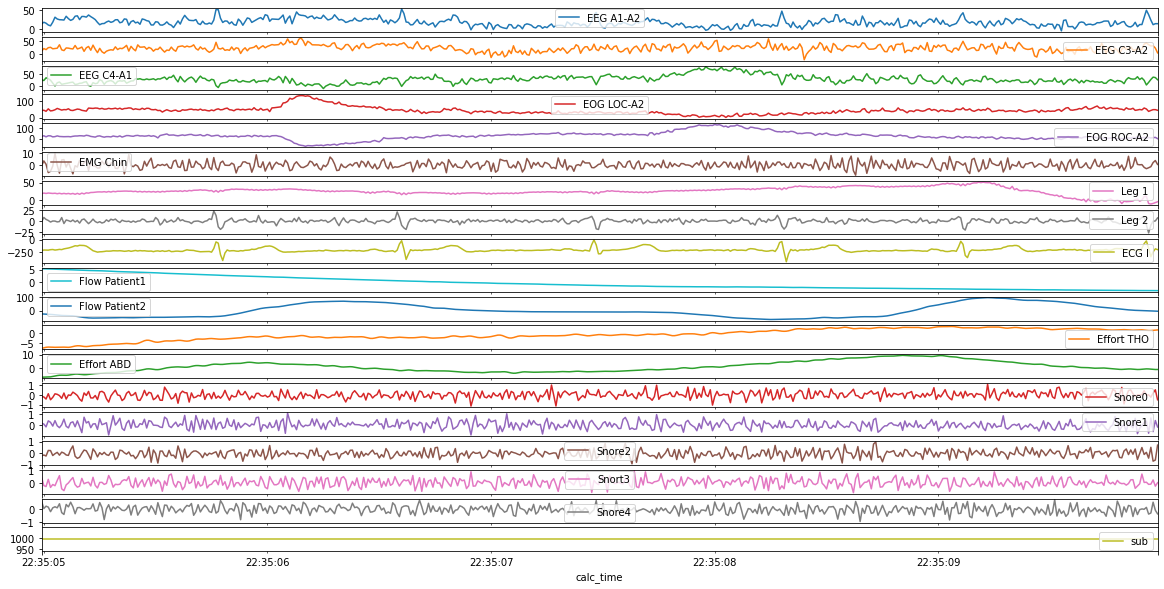

In [29]:
def get_df_from_pkl(sub_num):
    """this is modified version from the load_dataset notebook"""
    dataset_dir = '/content/drive/MyDrive/Processed_Datasets/PSG-Audio/PSG_18ch_100Hz_IR1' # path to the IR1 .zip files 
    pkl_ffname = os.path.join(dataset_dir,str(sub_num)+'_ir1_df.pkl')
    df = pd.read_pickle(pkl_ffname)
    return df

if interactive:
    sub_num = 995
    ir1_df = get_df_from_pkl(sub_num = sub_num)
    print("Dataframe shape is",ir1_df.shape)
    print("25 cols -> 9 200Hz + 4 100Hz + 5 500Hz + 6 labels + 1 sub")
    display(ir1_df.info())
    display(ir1_df.head())
    display(ir1_df.tail())
    y1 = 1000 # starting y value (row #)
    y2 = 2000 # ending, plotting the whole dataframe is too much.
    #ir1_df.iloc[499:999].plot(y='EEG A1-A2',subplots=True, layout=(1,2))
    ir1_df.iloc[499:999].plot(subplots=True, figsize=(20, 10)) # yay Pandas